# Tutorial 3: GW Detection Efficiency with GWFish

This notebook computes the **gravitational-wave detection efficiency** for BNS mergers associated with short GRBs, using the [GWFish](https://github.com/janosch314/GWFish) Fisher-matrix package.

## Setup

We start with a two-detector Einstein Telescope network:

| Label | Detectors |
|---|---|
| **ET 2L network** | `ETS_15`, `ETN_15` |

For each event in the GRB catalogue (produced in Tutorial 2), we:
1. Assign BNS parameters (masses, sky position, polarisation, …)
2. Compute the **network SNR** via GWFish
3. Apply an SNR threshold to determine detection
4. Derive the detection rate and its Poisson uncertainty

> **Exercise at the end:** You will extend the network by adding Cosmic Explorer (`CE40`) and compare the detection rates.

---

## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import notebook_setup

import multiprocessing as mp
cpus = mp.cpu_count()

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import GWFish.modules    as gw
from   astropy.cosmology import Planck18
from   pathlib           import Path

#plt.style.use('../configurations/style.mplstyle')

datafiles  = Path("../datafiles")
output_dir = Path("Output_files/tutorial3_gwfish")
output_dir.mkdir(parents=True, exist_ok=True)

---

## Background: Matched Filtering & Signal-to-Noise Ratio

Before diving into the pipeline, let's understand **what GWFish actually computes** when it returns an SNR value.

### The Data Stream

A GW detector measures a time-series of strain:

$$
d(t) = h_{\boldsymbol{\theta}}(t) + n(t)
$$

where $h_{\boldsymbol{\theta}}(t)$ is the gravitational-wave signal (parameterised by source properties $\boldsymbol{\theta}$) and $n(t)$ is detector noise. The noise has both **Gaussian** (thermal, quantum shot noise, seismic) and **non-Gaussian** (glitches, scattered light) components. For the purpose of detection, we model $n(t)$ as a stationary Gaussian process.

### Noise Characterisation: the Power Spectral Density

The statistical properties of the noise are fully captured by the one-sided **Power Spectral Density (PSD)** $S_n(f)$, defined via:

$$
\langle \tilde{n}(f)\, \tilde{n}^*(f') \rangle = \frac{1}{2}\, S_n(f)\, \delta(f - f')
$$

where $\tilde{n}(f)$ is the Fourier transform of $n(t)$. The PSD tells us the **noise power per unit frequency** — lower $S_n(f)$ means better sensitivity at that frequency. When we plot the PSDs below (Step 3), you will see the characteristic "bucket" shape: seismic noise dominates at low frequencies, shot noise at high frequencies, and the best sensitivity lies in between.

### The Noise-Weighted Inner Product

To optimally distinguish a signal from noise, we define a **noise-weighted inner product** between two frequency-domain signals:

$$
(a \mid b) = 4\, \mathrm{Re} \int_0^{\infty} \frac{\tilde{a}(f)\, \tilde{b}^*(f)}{S_n(f)}\, df
$$

This is the foundation of **matched filtering**: frequencies where the detector is noisy ($S_n$ large) are automatically down-weighted, while sensitive frequencies contribute more.

### Optimal SNR

The **optimal signal-to-noise ratio** — the quantity GWFish computes — is then:

$$
\rho_{\mathrm{opt}} = \sqrt{(h \mid h)} = \sqrt{4 \int_0^{\infty} \frac{|\tilde{h}(f)|^2}{S_n(f)}\, df}
$$

This represents the best possible SNR achievable with a perfectly matching template. It depends on: (i) the **signal amplitude** $|\tilde{h}(f)|$ (set by the source parameters), and (ii) the **detector noise** $S_n(f)$ (set by the instrument).

> **Intuition:** The integrand $|\tilde{h}(f)|^2 / S_n(f)$ is the *SNR density per frequency bin*. Plotting this "weighted strain" reveals which frequencies contribute most to the detection — for BNS systems, this is typically tens to hundreds of Hz where 3G detectors are most sensitive.

#### Toy Example: Recovering a Signal from Noise

To build intuition, here is a minimal matched-filtering demo. We bury a known sine-wave "signal" in Gaussian noise, then show how cross-correlating the data with the correct template recovers the signal and yields an SNR.

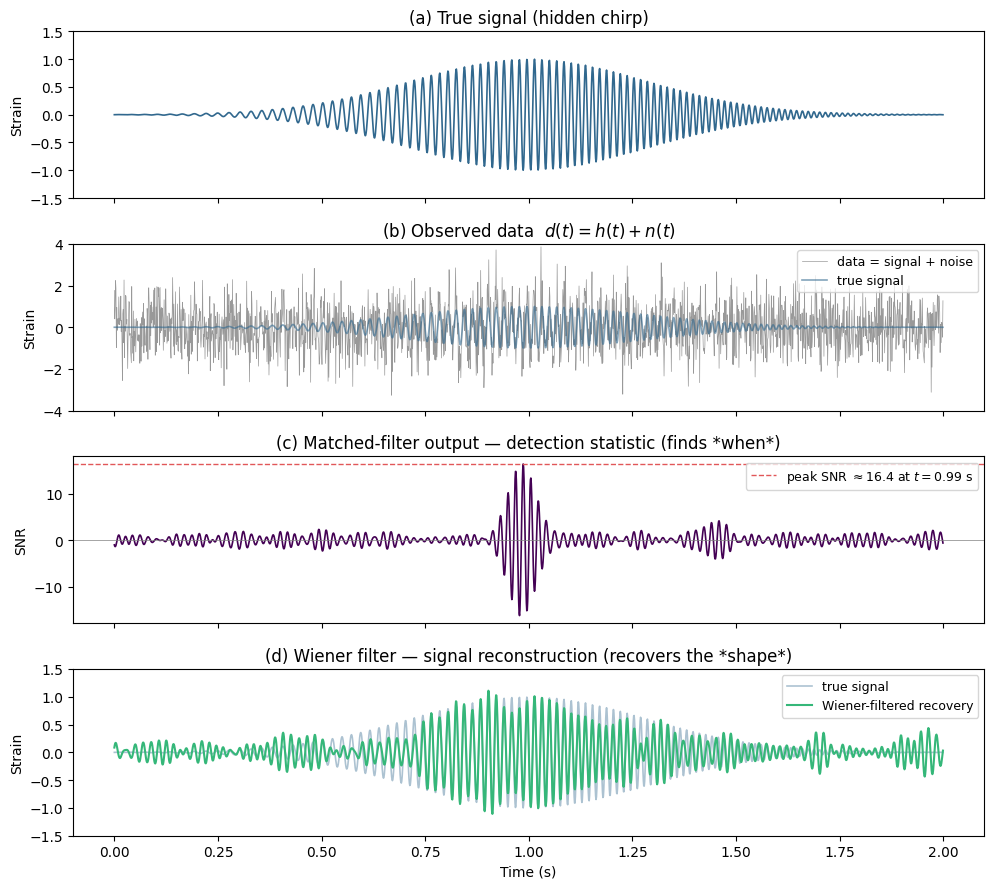

Panel (c): Matched filter peaks at SNR ≈ 16.4 — it finds the arrival time.
Panel (d): Wiener filter reconstructs the signal shape and duration from the noisy data.
GWFish computes the optimal SNR (panel c). Real PE pipelines also reconstruct waveforms (panel d).


In [19]:
# --- Toy matched-filtering example ---
np.random.seed(0)
from scipy.signal import windows
from scipy.fft import fft, ifft

# Time array
fs = 1024          # sampling rate (Hz)
T  = 2.0           # duration (s)
t  = np.arange(0, T, 1/fs)
N  = len(t)

# "Signal": a chirp-like sine wave (frequency sweeps from 30 to 80 Hz)
f0, f1 = 30, 80
phase  = 2 * np.pi * (f0 * t + (f1 - f0) / (2 * T) * t**2)
signal = 1.0 * np.sin(phase) * np.exp(-((t - T/2) / 0.4)**2)  # Gaussian envelope

# "Noise": white Gaussian noise (σ = 1)
noise = np.random.normal(0, 1, N)

# "Data": signal + noise
data = signal + noise

# ---- Matched filter (detection statistic) ----
# Shift template so peak is at t=0 → MF output peaks at signal's arrival time
peak_idx = np.argmax(np.abs(signal))
template = np.roll(signal, -peak_idx)

H_templ = fft(template)
D       = fft(data)
mf_output = np.real(ifft(D * np.conj(H_templ)))
mf_output /= np.sqrt(np.sum(signal**2))  # normalise so peak ≈ SNR

# ---- Wiener filter (signal reconstruction) ----
# Recovers the signal *shape* from noisy data: W(f) = |H|^2 / (|H|^2 + σ_n^2)
H_sig    = fft(signal)
sigma2   = 1.0  # known noise variance
wiener_W = np.abs(H_sig)**2 / (np.abs(H_sig)**2 + sigma2 * N)
recovered = np.real(ifft(D * wiener_W))

# --- Plot ---
fig, axes = plt.subplots(4, 1, figsize=(10, 9), sharex=True)

axes[0].plot(t, signal, color='#31688e', lw=1.2)
axes[0].set_ylabel('Strain')
axes[0].set_title('(a) True signal (hidden chirp)', fontsize=12)
axes[0].set_ylim(-1.5, 1.5)

axes[1].plot(t, data, color='grey', lw=0.5, alpha=0.8, label='data = signal + noise')
axes[1].plot(t, signal, color='#31688e', lw=1.2, alpha=0.6, label='true signal')
axes[1].set_ylabel('Strain')
axes[1].set_title('(b) Observed data  $d(t) = h(t) + n(t)$', fontsize=12)
axes[1].legend(fontsize=9, loc='upper right')
axes[1].set_ylim(-4, 4)

axes[2].plot(t, mf_output, color='#440154', lw=1.2)
axes[2].axhline(0, ls='-', color='grey', lw=0.5)
peak_snr = mf_output.max()
peak_time = t[np.argmax(mf_output)]
axes[2].axhline(peak_snr, ls='--', color='#e15759', lw=1,
                label=rf'peak SNR $\approx {peak_snr:.1f}$ at $t = {peak_time:.2f}$ s')
axes[2].set_ylabel('SNR')
axes[2].set_title('(c) Matched-filter output — detection statistic (finds *when*)', fontsize=12)
axes[2].legend(fontsize=9, loc='upper right')

axes[3].plot(t, signal, color='#31688e', lw=1.2, alpha=0.4, label='true signal')
axes[3].plot(t, recovered, color='#35b779', lw=1.5, label='Wiener-filtered recovery')
axes[3].set_ylabel('Strain')
axes[3].set_xlabel('Time (s)')
axes[3].set_title('(d) Wiener filter — signal reconstruction (recovers the *shape*)', fontsize=12)
axes[3].legend(fontsize=9, loc='upper right')
axes[3].set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()

print(f"Panel (c): Matched filter peaks at SNR ≈ {peak_snr:.1f} — it finds the arrival time.")
print("Panel (d): Wiener filter reconstructs the signal shape and duration from the noisy data.")
print("GWFish computes the optimal SNR (panel c). Real PE pipelines also reconstruct waveforms (panel d).")

## 1. Load the GRB Catalogue

We load the GRB catalogue produced in **Tutorial 2** (structured jet model, no artificial cuts).
This catalogue contains the redshift and viewing angle of each detected GRB.

In [2]:
cat_path = Path("Output_files/tutorial2_structured/simulated_catalogue.csv")
grb_cat  = pd.read_csv(cat_path)

print(f"Loaded catalogue with {len(grb_cat)} events")
print(f"Columns: {list(grb_cat.columns)}")
grb_cat.head()

Loaded catalogue with 716 events
Columns: ['z', 'theta_v', 'Ep_obs', 'Fp', 'T90']


,z,theta_v,Ep_obs,Fp,T90
0,1.415636,1.255996,1599.774032,3.326475,0.303101
1,4.289053,1.154894,256.338163,0.751587,0.982531
2,1.185732,0.726972,512.985027,1.304992,1.782053
3,1.006062,4.975575,355.805279,4.290123,0.135932
4,1.436368,1.906071,1173.864785,1.195041,1.919871


---

### Background: Waveform Physics & Binary Parameters

The SNR formula above depends on the signal $\tilde{h}(f)$, which is completely determined by the **source parameters**. Here we review the key physics that connects the parameters in our catalogue to the shape of the GW signal.

#### Polarisations

A compact binary coalescence (CBC) produces two independent polarisations of GW strain:

$$
h_+(t) \propto \frac{\mathcal{M}_c^{5/3}\, f^{2/3}}{d_L}\, \frac{1 + \cos^2 \iota}{2}\, \cos\Phi(t), \qquad
h_\times(t) \propto \frac{\mathcal{M}_c^{5/3}\, f^{2/3}}{d_L}\, \cos\iota\, \sin\Phi(t)
$$

where $\iota$ is the **inclination angle** (= $\theta_{jn}$ from our GRB catalogue), $d_L$ is the luminosity distance, $\Phi(t)$ is the orbital phase, and $\mathcal{M}_c$ is the **chirp mass**:

$$
\mathcal{M}_c = \frac{(m_1 m_2)^{3/5}}{(m_1 + m_2)^{1/5}}
$$

The chirp mass is the **best-measured** parameter in GW observations because it controls the leading-order frequency evolution of the signal $\dot{f} \propto \mathcal{M}_c^{5/3} f^{11/3}$.

#### Redshift and the Mass–Distance Degeneracy

GW detectors measure **redshifted ("detector-frame") masses**, not the source-frame masses:

$$
M_{\mathrm{obs}} = M_{\mathrm{source}} \,(1 + z)
$$

Since the luminosity distance $d_L$ and redshift $z$ are linked by cosmology, a **further, heavier** binary produces nearly the same waveform as a **closer, lighter** one. This mass–distance degeneracy is a fundamental limitation of GW-only observations and is one reason why **electromagnetic counterparts** (like the sGRBs from our catalogue) are so valuable — they independently constrain $z$.

## 2. Generate BNS Parameters

For each event in the catalogue we need the full set of parameters required by GWFish.
We draw masses from a **Gaussian** distribution centred on the Galactic double-NS population
($\mu = 1.33\,M_\odot$, $\sigma = 0.09\,M_\odot$) and randomise sky position, polarisation,
phase, and GPS time. The viewing angle $\theta_{jn}$ comes directly from the catalogue.

In [3]:
n_ev     = len(grb_cat)
redshift = grb_cat["z"].values

# Viewing angle from the GRB catalogue (stored in degrees → convert to radians for GWFish)
theta_jn = np.deg2rad(grb_cat["theta_v"].values)

# BNS masses — Gaussian (Galactic DNS population)
m1, m2 = np.random.normal(1.33, 0.09, (n_ev, 2)).T
# Enforce m1 >= m2
mass_1 = np.maximum(m1, m2)
mass_2 = np.minimum(m1, m2)

# Extrinsic parameters (randomised)
params_dict = {
    "mass_1_source"        : mass_1,
    "mass_2_source"        : mass_2,
    "redshift"             : redshift,
    "luminosity_distance"  : Planck18.luminosity_distance(redshift).value,
    "theta_jn"             : theta_jn,
    "ra"                   : np.random.uniform(0.0, 2 * np.pi, n_ev),
    "dec"                  : np.arcsin(np.random.uniform(-1.0, 1.0, n_ev)),
    "psi"                  : np.random.uniform(0.0, np.pi, n_ev),
    "phase"                : np.random.uniform(0.0, 2 * np.pi, n_ev),
    "geocent_time"         : np.random.uniform(1577491218, 1609027217, n_ev),
    "a_1"                  : np.zeros(n_ev),
    "a_2"                  : np.zeros(n_ev),
}

df_params = pd.DataFrame(params_dict)

# Save the generated parameters for reproducibility
df_params.to_csv(output_dir / "bns_params.csv", index=False)

print(f"Generated {n_ev} BNS parameter sets")
print(f"  <m1> = {mass_1.mean():.3f} Msun,  <m2> = {mass_2.mean():.3f} Msun")
print(f"  z ∈ [{redshift.min():.3f}, {redshift.max():.3f}]")
df_params.head()

Generated 716 BNS parameter sets
  <m1> = 1.383 Msun,  <m2> = 1.276 Msun
  z ∈ [0.077, 7.138]


,mass_1_source,mass_2_source,redshift,luminosity_distance,theta_jn,ra,dec,psi,phase,geocent_time,a_1,a_2
0,1.346837,1.263713,1.415636,10423.384411,0.021921,2.226126,-0.477595,2.562928,3.816972,1.601854e+09,0.0,0.0
1,1.528181,1.215226,4.289053,39810.647221,0.020157,5.970543,0.464268,0.070029,4.852231,1.598927e+09,0.0,0.0
2,1.327049,1.229784,1.185732,8378.321342,0.012688,3.643638,0.582195,0.495682,4.362396,1.605754e+09,0.0,0.0
3,1.465627,1.238579,1.006062,6842.022386,0.086840,4.521687,0.377468,1.641903,0.963937,1.607602e+09,0.0,0.0
4,1.288927,1.256483,1.436368,10611.625959,0.033267,4.527660,-0.586511,0.936680,1.943180,1.596175e+09,0.0,0.0


---

### Background: The Fisher Information Matrix (the "Fish" in GWFish)

GWFish doesn't just compute SNR — it can also estimate **how well each parameter can be measured**. Here we briefly sketch the underlying method. (**Tutorial 4** will explore parameter estimation in more detail.)

#### From Bayes' Theorem to the Likelihood

Given data $d$, the posterior on the source parameters $\boldsymbol{\theta}$ is:

$$
p(\boldsymbol{\theta} \mid d) \propto \mathcal{L}(d \mid \boldsymbol{\theta})\, \pi(\boldsymbol{\theta})
$$

where $\mathcal{L}$ is the likelihood and $\pi$ is the prior. For a Gaussian-noise detector, the log-likelihood is:

$$
\ln \mathcal{L} \propto -\frac{1}{2} (d - h(\boldsymbol{\theta}) \mid d - h(\boldsymbol{\theta}))
$$

using the same noise-weighted inner product defined above.

#### The Gaussian Approximation (High-SNR Limit)

In the **high-SNR regime**, the likelihood can be Taylor-expanded around the true parameters $\hat{\boldsymbol{\theta}}$ and approximated as a **multivariate Gaussian**:

$$
\mathcal{L}(d \mid \boldsymbol{\theta}) \approx \mathcal{N}\, \exp\!\left(-\frac{1}{2}\, \Delta\theta^i\, F_{ij}\, \Delta\theta^j\right)
$$

where $\Delta \theta^i = \theta^i - \hat{\theta}^i$ and $F_{ij}$ is the **Fisher Information Matrix**.

#### Fisher Matrix Elements

The Fisher matrix is computed from the **derivatives of the waveform** with respect to each parameter:

$$
F_{ij} = \left(\frac{\partial h}{\partial \theta^i} \bigg| \frac{\partial h}{\partial \theta^j}\right) = 4\, \mathrm{Re} \int_0^{\infty} \frac{\partial_{\theta^i} \tilde{h}(f)\;\partial_{\theta^j} \tilde{h}^*(f)}{S_n(f)}\, df
$$

Intuitively, if changing a parameter significantly alters the waveform (large $\partial h / \partial \theta$), then the data constrains that parameter tightly.

#### From Fisher to Parameter Errors

The **inverse** of the Fisher matrix gives the **covariance matrix**:

$$
C_{ij} = (F^{-1})_{ij}, \qquad \sigma_{\theta^i} = \sqrt{C_{ii}}
$$

and the off-diagonal terms encode **correlations** between parameters: $\rho_{ij} = C_{ij} / (\sigma_i \sigma_j)$.

> **Note:** In this tutorial we only use GWFish for SNR computation. In **Tutorial 4**, we will use the full Fisher matrix to estimate sky localisation and parameter uncertainties, and visualise parameter correlations with corner plots.

## 3. Set Up the GWFish Detector Network

### Background: Detector Response & Antenna Patterns

A single detector does not measure $h_+$ and $h_\times$ independently. The measured strain is a **linear combination** weighted by the **antenna pattern functions**:

$$
h(t) = F_+(\alpha, \delta, \psi, t)\, h_+(t) + F_\times(\alpha, \delta, \psi, t)\, h_\times(t)
$$

where $F_+$ and $F_\times$ depend on the source sky position (RA $\alpha$, Dec $\delta$), polarisation angle $\psi$, and the detector's orientation and geometry. Every detector has **blind spots** — sky directions where $F_+ \approx F_\times \approx 0$.

### Network SNR

For a network of $N$ detectors, the total SNR is the **quadrature sum** of the individual detector SNRs:

$$
\rho_{\mathrm{net}} = \sqrt{\sum_{k=1}^{N} \rho_k^2}
$$

Similarly, the Fisher information matrices **add**: $F_{ij}^{\mathrm{net}} = \sum_k F_{ij}^{(k)}$, meaning more detectors always improve parameter estimation.

### Why 3G Detectors (ET / CE)?

- **Einstein Telescope (ET):** Originally designed as a triangular underground detector, effectively equivalent to 3 co-located interferometers. The **2L configuration** used here (two separated L-shaped detectors, ETS and ETN) reduces blind spots compared to a single L-shaped detector and provides independent noise realisations, improving both detection confidence and sky localisation.
- **Cosmic Explorer (CE):** A 40 km L-shaped surface detector with extraordinary low-frequency sensitivity. When combined with ET, the long baseline ($\sim$5000 km) dramatically improves sky localisation via triangulation.

We start with the **Einstein Telescope 2L** configuration:

| Detector | Description |
|---|---|
| `ETS_15` | Einstein Telescope — South, 15 km arms |
| `ETN_15` | Einstein Telescope — North, 15 km arms |

Resolved config written to: /tmp/gwfish_conf_0epzmgi6.yaml


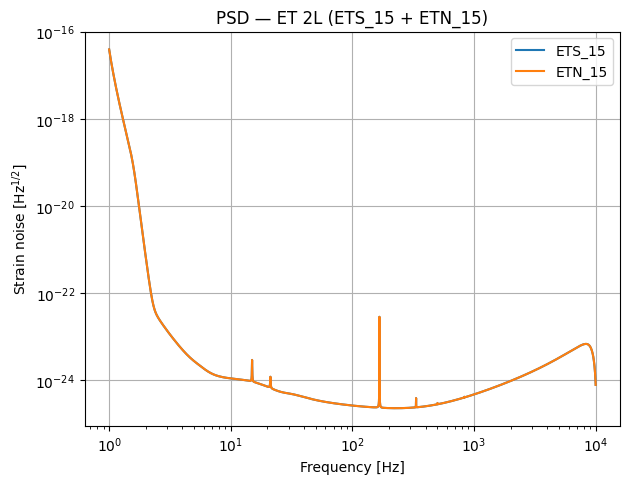

Network initialised with detectors: ['ETS_15', 'ETN_15']


In [4]:
import re, tempfile

# ---------- Detector configuration ----------
# Source YAML (contains bare PSD filenames like "ET_15_coba.txt")
yaml_template = Path("configs/coba.yaml")

# Directory containing the local PSD files
psd_dir = Path("psds").resolve()

def resolve_psd_paths(yaml_path, psd_dir):
    """Read a GWFish config YAML and resolve every bare `psd_data` filename
    to an absolute path under *psd_dir*. Returns the path to a temporary
    YAML file with all paths resolved. Makes it safe to pass to GWFish."""
    text = yaml_path.read_text()
    # Match `psd_data:` followed by a value that is NOT already an absolute path
    def _resolve(m):
        fname = m.group(1).strip()
        if fname.startswith("/"):        # already absolute → keep as-is
            return m.group(0)
        resolved = (psd_dir / fname).resolve()
        if not resolved.exists():
            raise FileNotFoundError(
                f"PSD file not found: {resolved}  (referenced in {yaml_path})"
            )
        return f"psd_data:{m.group(0).split('psd_data:')[1].replace(fname, str(resolved))}"
    resolved_text = re.sub(r"psd_data:\s*(.+)", _resolve, text)
    # Write to a temp file that GWFish can read
    tmp = tempfile.NamedTemporaryFile(
        mode="w", suffix=".yaml", prefix="gwfish_conf_", delete=False
    )
    tmp.write(resolved_text)
    tmp.flush()
    return Path(tmp.name)

conf_file = resolve_psd_paths(yaml_template, psd_dir)
print(f"Resolved config written to: {conf_file}")

# Network: ET 2L (South + North, 15 km arms)
detector_names = ["ETS_15", "ETN_15"]

waveform_model = "IMRPhenomD_NRTidalv2"

network = gw.detection.Network(
    detector_ids  = detector_names,
    config        = conf_file,
    detection_SNR = (0, 8),
)

# Quick sanity check: plot the PSDs
for det in network.detectors:
    det.components[0].plot_psd()
plt.legend(detector_names)
plt.title("PSD — ET 2L (ETS_15 + ETN_15)")
plt.savefig(output_dir / "PSDs.pdf")
plt.show()
print(f"Network initialised with detectors: {detector_names}")

## 4. Compute Network SNR (Multiprocessing)

We compute the SNR for every event using `gw.utilities.get_snr`, split across all available CPU cores.
The last column of the returned array is the **network (quadrature-summed) SNR**.

In [5]:
from joblib import Parallel, delayed

my_pop_split = np.array_split(df_params, cpus)

def run_snr(chunk_df):
    return gw.utilities.get_snr(chunk_df, network=network, waveform_model=waveform_model)

snr_chunks = Parallel(n_jobs=cpus, verbose=10)(
    delayed(run_snr)(chunk) for chunk in my_pop_split
)

snr_array = np.concatenate(snr_chunks)   # shape: (n_ev, n_detectors + 1)

# Individual detector SNRs and network SNR
individual_snrs = snr_array[:, :-1]
network_snr     = snr_array[:, -1]

print(f"SNR computed for {len(network_snr)} events")
print(f"  Median network SNR : {np.median(network_snr):.1f}")
print(f"  Max    network SNR : {np.max(network_snr):.1f}")

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:    5.7s remaining:   17.1s
[Parallel(n_jobs=12)]: Done   5 out of  12 | elapsed:    5.7s remaining:    8.0s
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:    5.8s remaining:    4.1s
[Parallel(n_jobs=12)]: Done   9 out of  12 | elapsed:    5.9s remaining:    2.0s


SNR computed for 716 events
  Median network SNR : 10.1
  Max    network SNR : 144.7


[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    6.1s finished


### Fallback: Single-Process SNR Computation

If multiprocessing causes issues (e.g., on some systems or inside containers), uncomment and run
the cell below **instead** of the multiprocessing cell above.

In [6]:
# # --- Single-process fallback (uncomment if multiprocessing fails) ---
# snr_array   = gw.utilities.get_snr(df_params, network=network, waveform_model=waveform_model)
#
# individual_snrs = np.array(snr_array)[:, :-1]
# network_snr     = np.array(snr_array)[:, -1]
#
# print(f"SNR computed for {len(network_snr)} events (single process)")
# print(f"  Median network SNR : {np.median(network_snr):.1f}")
# print(f"  Max    network SNR : {np.max(network_snr):.1f}")

## 5. Detection Rate & Redshift Distribution

### Background: Detection Threshold & Statistics

#### Why SNR > 8?

In real GW data, noise fluctuations can occasionally mimic a signal. For Gaussian noise, the amplitude of these fluctuations follows a **$\chi^2$ distribution**. The threshold $\rho > 8$ is chosen so that the probability of a pure noise fluctuation exceeding this value — the **false alarm rate (FAR)** — is negligibly small (roughly one false trigger per $\sim 10^5$ years for a single template). This ensures that any event crossing the threshold is almost certainly astrophysical.

#### Detection Efficiency

The **detection fraction** (or efficiency) is:

$$
\eta = \frac{N_{\mathrm{det}}}{N_{\mathrm{total}}}
$$

Since detection is a **counting process**, the uncertainty on $N_{\mathrm{det}}$ follows **Poisson statistics**: $\Delta N_{\mathrm{det}} = \sqrt{N_{\mathrm{det}}}$, giving:

$$
\eta = \frac{N_{\mathrm{det}} \pm \sqrt{N_{\mathrm{det}}}}{N_{\mathrm{total}}}
$$

By comparing the redshift distribution of *all* events vs. *detected* events, we can directly see how $\eta(z)$ decreases with distance — the SNR scales as $\rho \propto 1/d_L$, so distant mergers progressively fall below threshold.

['ETS_15', 'ETN_15'] detected 468 / 716  (SNR > 8.0)
Detection rate: 0.654  [0.623, 0.684]


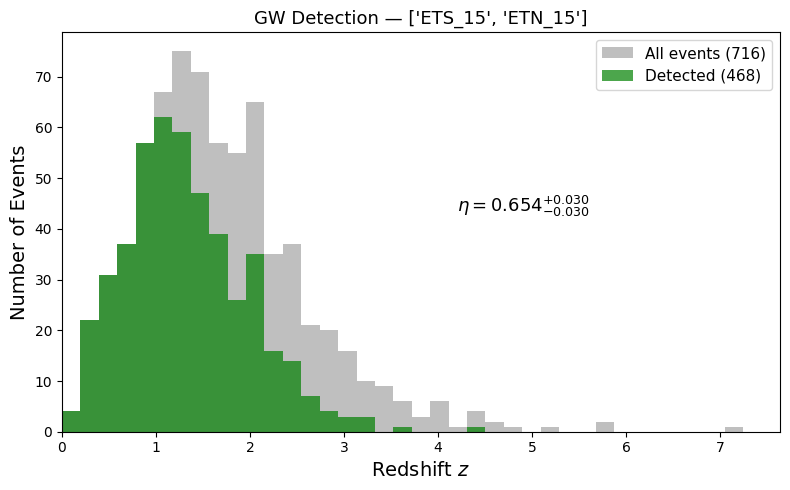

In [7]:
SNR_THRESHOLD = 8.0

detected_mask   = network_snr > SNR_THRESHOLD
total_events    = len(network_snr)
detected_events = int(np.sum(detected_mask))

# Poisson uncertainty on the detection count
poisson_err = np.sqrt(detected_events)
ratio       = detected_events / total_events
ratio_plus  = (detected_events + poisson_err) / total_events
ratio_minus = (detected_events - poisson_err) / total_events

print(f"{detector_names} detected {detected_events} / {total_events}  (SNR > {SNR_THRESHOLD})")
print(f"Detection rate: {ratio:.3f}  [{ratio_minus:.3f}, {ratio_plus:.3f}]")

# ---- Redshift histogram ----
bins = np.linspace(0, redshift.max() + 0.5, 40)

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(redshift, bins=bins, color="gray", alpha=0.5,
        label=f"All events ({total_events})")
ax.hist(redshift[detected_mask], bins=bins, color="green", alpha=0.7,
        label=f"Detected ({detected_events})")
ax.text(
    0.55, 0.55,
    f"$\\eta = {{{ratio:.3f}}}^{{+{ratio_plus - ratio:.3f}}}_{{-{ratio - ratio_minus:.3f}}}$",
    transform=ax.transAxes, fontsize=13,
)
ax.set_xlabel("Redshift $z$", fontsize=14)
ax.set_ylabel("Number of Events", fontsize=14)
ax.set_title(f"GW Detection — {detector_names}", fontsize=13)
ax.set_xlim(0, redshift.max() + 0.5)
ax.legend(fontsize=11)
plt.tight_layout()
plt.savefig(output_dir / "detection_redshift_hist.pdf", dpi=300, bbox_inches="tight")
plt.show()

## 6. Save Results

Save the full catalogue augmented with the network SNR and the detection mask
so it can be used downstream (e.g., for joint GW+GRB population studies).

In [8]:
# Augment the original catalogue with SNR info
results_df = grb_cat.copy()
for i, det_name in enumerate(detector_names):
    results_df[f"snr_{det_name}"] = individual_snrs[:, i]
results_df["snr_network"] = network_snr
results_df["detected"]    = detected_mask

# Save
results_df.to_csv(output_dir / "catalogue_with_snr.csv", index=False)

print(f"Saved augmented catalogue to {output_dir / 'catalogue_with_snr.csv'}")
print(f"Columns: {list(results_df.columns)}")
results_df.head()

Saved augmented catalogue to Output_files/tutorial3_gwfish/catalogue_with_snr.csv
Columns: ['z', 'theta_v', 'Ep_obs', 'Fp', 'T90', 'snr_ETS_15', 'snr_ETN_15', 'snr_network', 'detected']


,z,theta_v,Ep_obs,Fp,T90,snr_ETS_15,snr_ETN_15,snr_network,detected
0,1.415636,1.255996,1599.774032,3.326475,0.303101,7.726760,7.209373,10.567775,True
1,4.289053,1.154894,256.338163,0.751587,0.982531,4.781149,4.897866,6.844595,False
2,1.185732,0.726972,512.985027,1.304992,1.782053,4.422111,7.932813,9.082102,True
3,1.006062,4.975575,355.805279,4.290123,0.135932,15.546504,14.500249,21.259140,True
4,1.436368,1.906071,1173.864785,1.195041,1.919871,11.219100,10.699508,15.503150,True


### Diagnostic Plots

Let's visualise the results to build physical intuition. The **left panel** shows redshift vs. network SNR — you should see the expected $\rho \propto 1/d_L \sim 1/z$ scaling. The **right panel** shows a sky map coloured by individual detector SNR, revealing the antenna pattern's directional sensitivity.

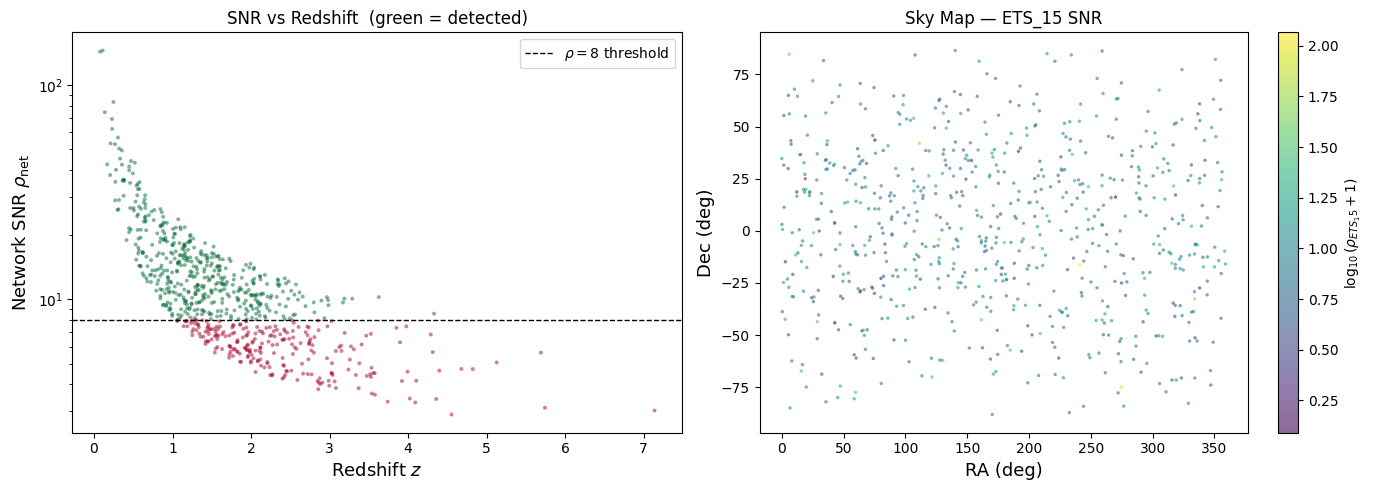

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Redshift vs Network SNR (the 1/d_L scaling) ---
ax = axes[0]
sc = ax.scatter(redshift, network_snr, c=detected_mask, cmap="RdYlGn",
                s=8, alpha=0.5, edgecolors="none")
ax.axhline(SNR_THRESHOLD, ls="--", color="k", lw=1, label=rf"$\rho = {SNR_THRESHOLD:.0f}$ threshold")
ax.set_yscale("log")
ax.set_xlabel("Redshift $z$", fontsize=13)
ax.set_ylabel("Network SNR $\\rho_{\\mathrm{net}}$", fontsize=13)
ax.set_title("SNR vs Redshift  (green = detected)", fontsize=12)
ax.legend(fontsize=10)

# --- Right: Sky map coloured by SNR of the first detector ---
ax = axes[1]
ra_plot  = np.rad2deg(df_params["ra"].values)
dec_plot = np.rad2deg(df_params["dec"].values)
sc2 = ax.scatter(ra_plot, dec_plot, c=np.log10(individual_snrs[:, 0] + 1),
                 cmap="viridis", s=6, alpha=0.6, edgecolors="none")
cbar = plt.colorbar(sc2, ax=ax, label=rf"$\log_{{10}}(\rho_{{{detector_names[0]}}} + 1)$")
ax.set_xlabel("RA (deg)", fontsize=13)
ax.set_ylabel("Dec (deg)", fontsize=13)
ax.set_title(f"Sky Map — {detector_names[0]} SNR", fontsize=12)

plt.tight_layout()
plt.savefig(output_dir / "diagnostic_snr_sky.pdf", dpi=200, bbox_inches="tight")
plt.show()

---

## Exercise: Add Cosmic Explorer to the Network

Now it's your turn! Re-run the detection analysis with an **expanded network** that includes
`CE40` (Cosmic Explorer, 40 km arms) alongside the two ET detectors.

**Steps:**
1. Inspect the available detectors in the configuration file (printed below).
2. Define a new `detector_names` list that includes `CE40`.
3. Build a new `Network`, compute SNRs, and compare the detection rate to the ET-only result.

**Hint:** You only need to change `detector_names` and re-run the SNR computation.

In [10]:
# Print all available detector entries from the configuration YAML
print("Available detectors in coba.yaml:")
print("=" * 40)
with open(yaml_template) as f:
    for line in f:
        # Print top-level detector names (no leading whitespace, ending with ':')
        stripped = line.rstrip()
        if stripped and not stripped.startswith(" ") and not stripped.startswith("#") and stripped.endswith(":"):
            print(f"  • {stripped[:-1]}")

Available detectors in coba.yaml:
  • ET
  • ETS_15
  • ETN_15
  • CE40
  • CE20


In [11]:
# ============================================================
# EXERCISE: Define the extended network and compute SNRs
# ============================================================

# TODO: Add CE40 to the detector list
detector_names_ext = ["ETS_15", "ETN_15"]  # <-- modify this line!

network_ext = gw.detection.Network(
    detector_ids  = detector_names_ext,
    config        = conf_file,
    detection_SNR = (0, 8),
)

# Compute SNR (single-process for simplicity; swap for joblib version if you prefer)
snr_array_ext   = gw.utilities.get_snr(df_params, network=network_ext, waveform_model=waveform_model)
network_snr_ext = np.array(snr_array_ext)[:, -1]

detected_ext = int(np.sum(network_snr_ext > SNR_THRESHOLD))
ratio_ext    = detected_ext / total_events

print(f"Extended network: {detector_names_ext}")
print(f"  Detected {detected_ext} / {total_events}  (SNR > {SNR_THRESHOLD})")
print(f"  Detection rate: {ratio_ext:.3f}")
print(f"\nOriginal ET-only rate: {ratio:.3f}")
print(f"Improvement factor:   {ratio_ext / ratio:.2f}x" if ratio > 0 else "")

Extended network: ['ETS_15', 'ETN_15']
  Detected 468 / 716  (SNR > 8.0)
  Detection rate: 0.654

Original ET-only rate: 0.654
Improvement factor:   1.00x


---

## Summary

In this notebook we:

1. **Reviewed the theory** of matched filtering, the noise-weighted inner product, and the optimal SNR
2. **Connected source parameters** to the GW signal: chirp mass, inclination, redshifted masses, and tidal deformability
3. **Introduced the Fisher matrix** as GWFish's approximation to the likelihood (explored further in Tutorial 4)
4. **Explained detector networks**: antenna patterns, network SNR as a quadrature sum, and why ET + CE improves coverage
5. **Built a pipeline**: loaded GRB catalogues, generated BNS parameters, computed SNR with GWFish
6. **Applied a detection threshold** ($\rho > 8$) with Poisson uncertainties and visualised the redshift-dependent detection efficiency

**Exercise:** Extended the network with `CE40` and compared detection rates.